In [1]:
!pip install timm


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import timm


In [109]:
features = np.load("features.npy")     # Shape: (num_samples, 16, 64, 64, 3)
labels = np.load("labels.npy")         # Shape: (num_samples,)
SEQUENCE_LENGTH = 16
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64


DATASET_DIR = r"C:\Users\sathv\Downloads\mini\RealLifeViolenceDataset"
 
CLASSES_LIST = ["NonViolence","Violence"]

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels)


In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_vit_feature_extractor():
    input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    
    # Use a lightweight transformer (or substitute ViT with ResNet for now, since ViT input should be 224x224)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    x = base_model(input_layer)
    x = GlobalAveragePooling2D()(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model


In [34]:
def build_vit_lstm_model(sequence_length, image_height, image_width, num_classes=2):
    input_shape = (sequence_length, image_height, image_width, 3)
    input_layer = Input(shape=input_shape)

    # Feature extractor
    vit_model = build_vit_feature_extractor()

    # TimeDistributed ViT
    x = TimeDistributed(vit_model)(input_layer)

    # Temporal modeling
    x = LSTM(128, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Classification
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [6]:
model = build_vit_lstm_model(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, num_classes=2)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

# Train
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=8,
    validation_split=0.2
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 2048)       │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,710,722 (94.26 MB)

 Trainable params: 24,657,602 (94.06 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2003s 9s/step - accuracy: 0.6531 - loss: 0.6141 - val_accuracy: 0.8313 - val_loss: 0.3417
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1317s 8s/step - accuracy: 0.8498 - loss: 0.3362 - val_accuracy: 0.9062 - val_loss: 0.2314
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1317s 8s/step - accuracy: 0.9214 - loss: 0.2014 - val_accuracy: 0.8844 - val_loss: 0.2411
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1303s 8s/step - accuracy: 0.9452 - loss: 0.1582 - val_accuracy: 0.9125 - val_loss: 0.2076
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1289s 8s/step - accuracy: 0.9598 - loss: 0.1222 - val_accuracy: 0.9219 - val_loss: 0.2110
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1387s 8s/step - accuracy: 0.9500 - loss: 0.1409 - val_accuracy: 0.9438 - val_loss: 0.1537
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1338s 8s/step - accuracy: 0.9538 - loss: 0.1151 - val_accuracy: 0.9500 - val_loss: 0.1737
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1166s 7s/step - accuracy: 0.9554 - loss: 0.1150 - 

In [7]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.9370 - loss: 0.1506
Test Accuracy: 92.75%


In [16]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step


Evaluation

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [105]:
def plot_metric(history, metric1, metric2, title):
    metric1_values = history.history[metric1]
    metric2_values = history.history[metric2]
    epochs = range(len(metric1_values))
    
    plt.figure(figsize=(4, 4))
    plt.plot(epochs, metric1_values, 'b', label=metric1)
    plt.plot(epochs, metric2_values, 'orange', label=metric2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric1.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

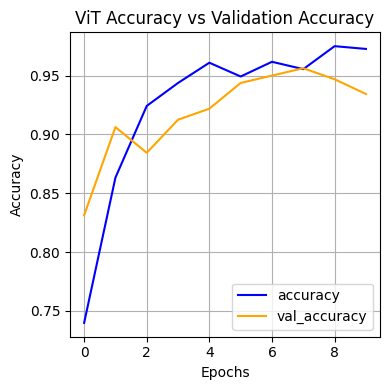

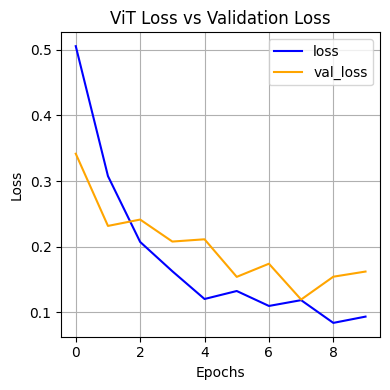

In [107]:
plot_metric(history, 'accuracy', 'val_accuracy', 'ViT Accuracy vs Validation Accuracy')
plot_metric(history, 'loss', 'val_loss', 'ViT Loss vs Validation Loss')


13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step
Classification Report:

              precision    recall  f1-score   support

 NonViolence       0.93      0.93      0.93       200
    Violence       0.93      0.93      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



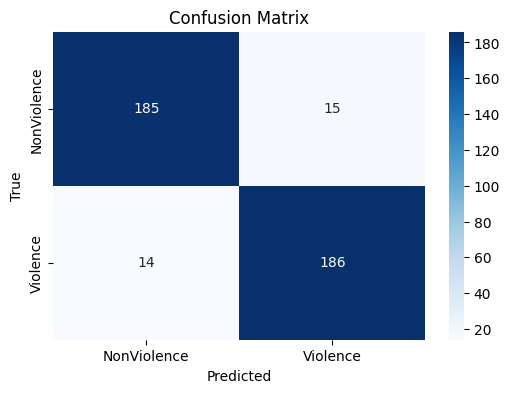

In [103]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert to predicted labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["NonViolence", "Violence"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NonViolence", "Violence"], yticklabels=["NonViolence", "Violence"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# **Prediction For the Video**

In [49]:
def frames_extraction(video_path):
    from tensorflow.keras.applications.vgg16 import preprocess_input
    
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        preprocessed_frame = preprocess_input(resized_frame)  # Use this instead
        frames_list.append(preprocessed_frame)

    video_reader.release()
    return frames_list


In [51]:
def predict_video_violence(video_path, model):
    from tensorflow.keras.preprocessing import image

    frames = frames_extraction(video_path)

    if len(frames) != SEQUENCE_LENGTH:
        print("Insufficient frames for prediction. Skipping video.")
        return

    # Preprocess
    input_data = np.expand_dims(np.array(frames), axis=0)  # shape (1, 16, 64, 64, 3)

    prediction = model.predict(input_data)
    class_index = np.argmax(prediction[0])
    confidence = prediction[0][class_index]

    class_label = CLASSES_LIST[class_index]
    print(f"Prediction: {class_label} ({confidence * 100:.2f}%)")

    return class_label, confidence


In [53]:
import cv2
predict_video_violence(r"C:\Users\sathv\Downloads\V.avi", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
Prediction: NonViolence (67.78%)


('NonViolence', 0.6778021)

In [54]:
import cv2
predict_video_violence(r"C:\Users\sathv\Downloads\NVV.avi", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
Prediction: NonViolence (61.40%)


('NonViolence', 0.6140258)

In [55]:
import cv2
predict_video_violence(r"C:\Users\sathv\Downloads\NV.avi", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
Prediction: NonViolence (58.53%)


('NonViolence', 0.585347)

# **Prediction Frame by Frame**

In [148]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque


In [178]:
def predict_frames_vit(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'),
                                   video_reader.get(cv2.CAP_PROP_FPS), 
                                   (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame 
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            input_batch = np.expand_dims(frames_queue, axis=0)  # (1, 16, 64, 64, 3)
            predicted_probs = model.predict(input_batch, verbose=0)[0]
            predicted_label = np.argmax(predicted_probs)
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Annotate the video frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.2
        font_thickness = 3
        text_color = (0, 255, 0) if predicted_class_name == "NonViolence" else (0, 0, 255)
        bg_color = (0, 0, 0)
        text_position = (10, 50)

        (text_width, text_height), _ = cv2.getTextSize(predicted_class_name, font, font_scale, font_thickness)

        cv2.rectangle(frame,
                      (text_position[0] - 5, text_position[1] - text_height - 5),
                      (text_position[0] + text_width + 5, text_position[1] + 5),
                      bg_color, -1)
        cv2.putText(frame, predicted_class_name, text_position, font, font_scale, text_color, font_thickness, cv2.LINE_AA)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()


In [180]:
def show_pred_frames(pred_video_path, frame_size=(224, 224)):  
    plt.figure(figsize=(20, 15))

    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    if frames_count <= SEQUENCE_LENGTH:
        print(f"Not enough frames in the video. Frames count: {frames_count}, SEQUENCE_LENGTH: {SEQUENCE_LENGTH}")
        return

    num_samples = min(12, max(0, frames_count - SEQUENCE_LENGTH))
    if num_samples == 0:
        print("Not enough frames to sample.")
        return

    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), num_samples))

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(3, 4, counter)
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()
        if not ok:
            print(f"Warning: Could not read frame at index {random_index}")
            continue  

        frame = cv2.resize(frame, frame_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.axis("off")

    video_reader.release()
    plt.tight_layout()
    plt.show()


In [182]:
import os
import time
# Construct the output video path.
test_videos_directory = 'ViT_output'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/Output-Test-Video-{int(time.time())}.mp4'


#if os.path.exists(output_video_file_path):
#    os.remove(output_video_file_path)


'\nif os.path.exists(output_video_file_path):\n    os.remove(output_video_file_path)\n'

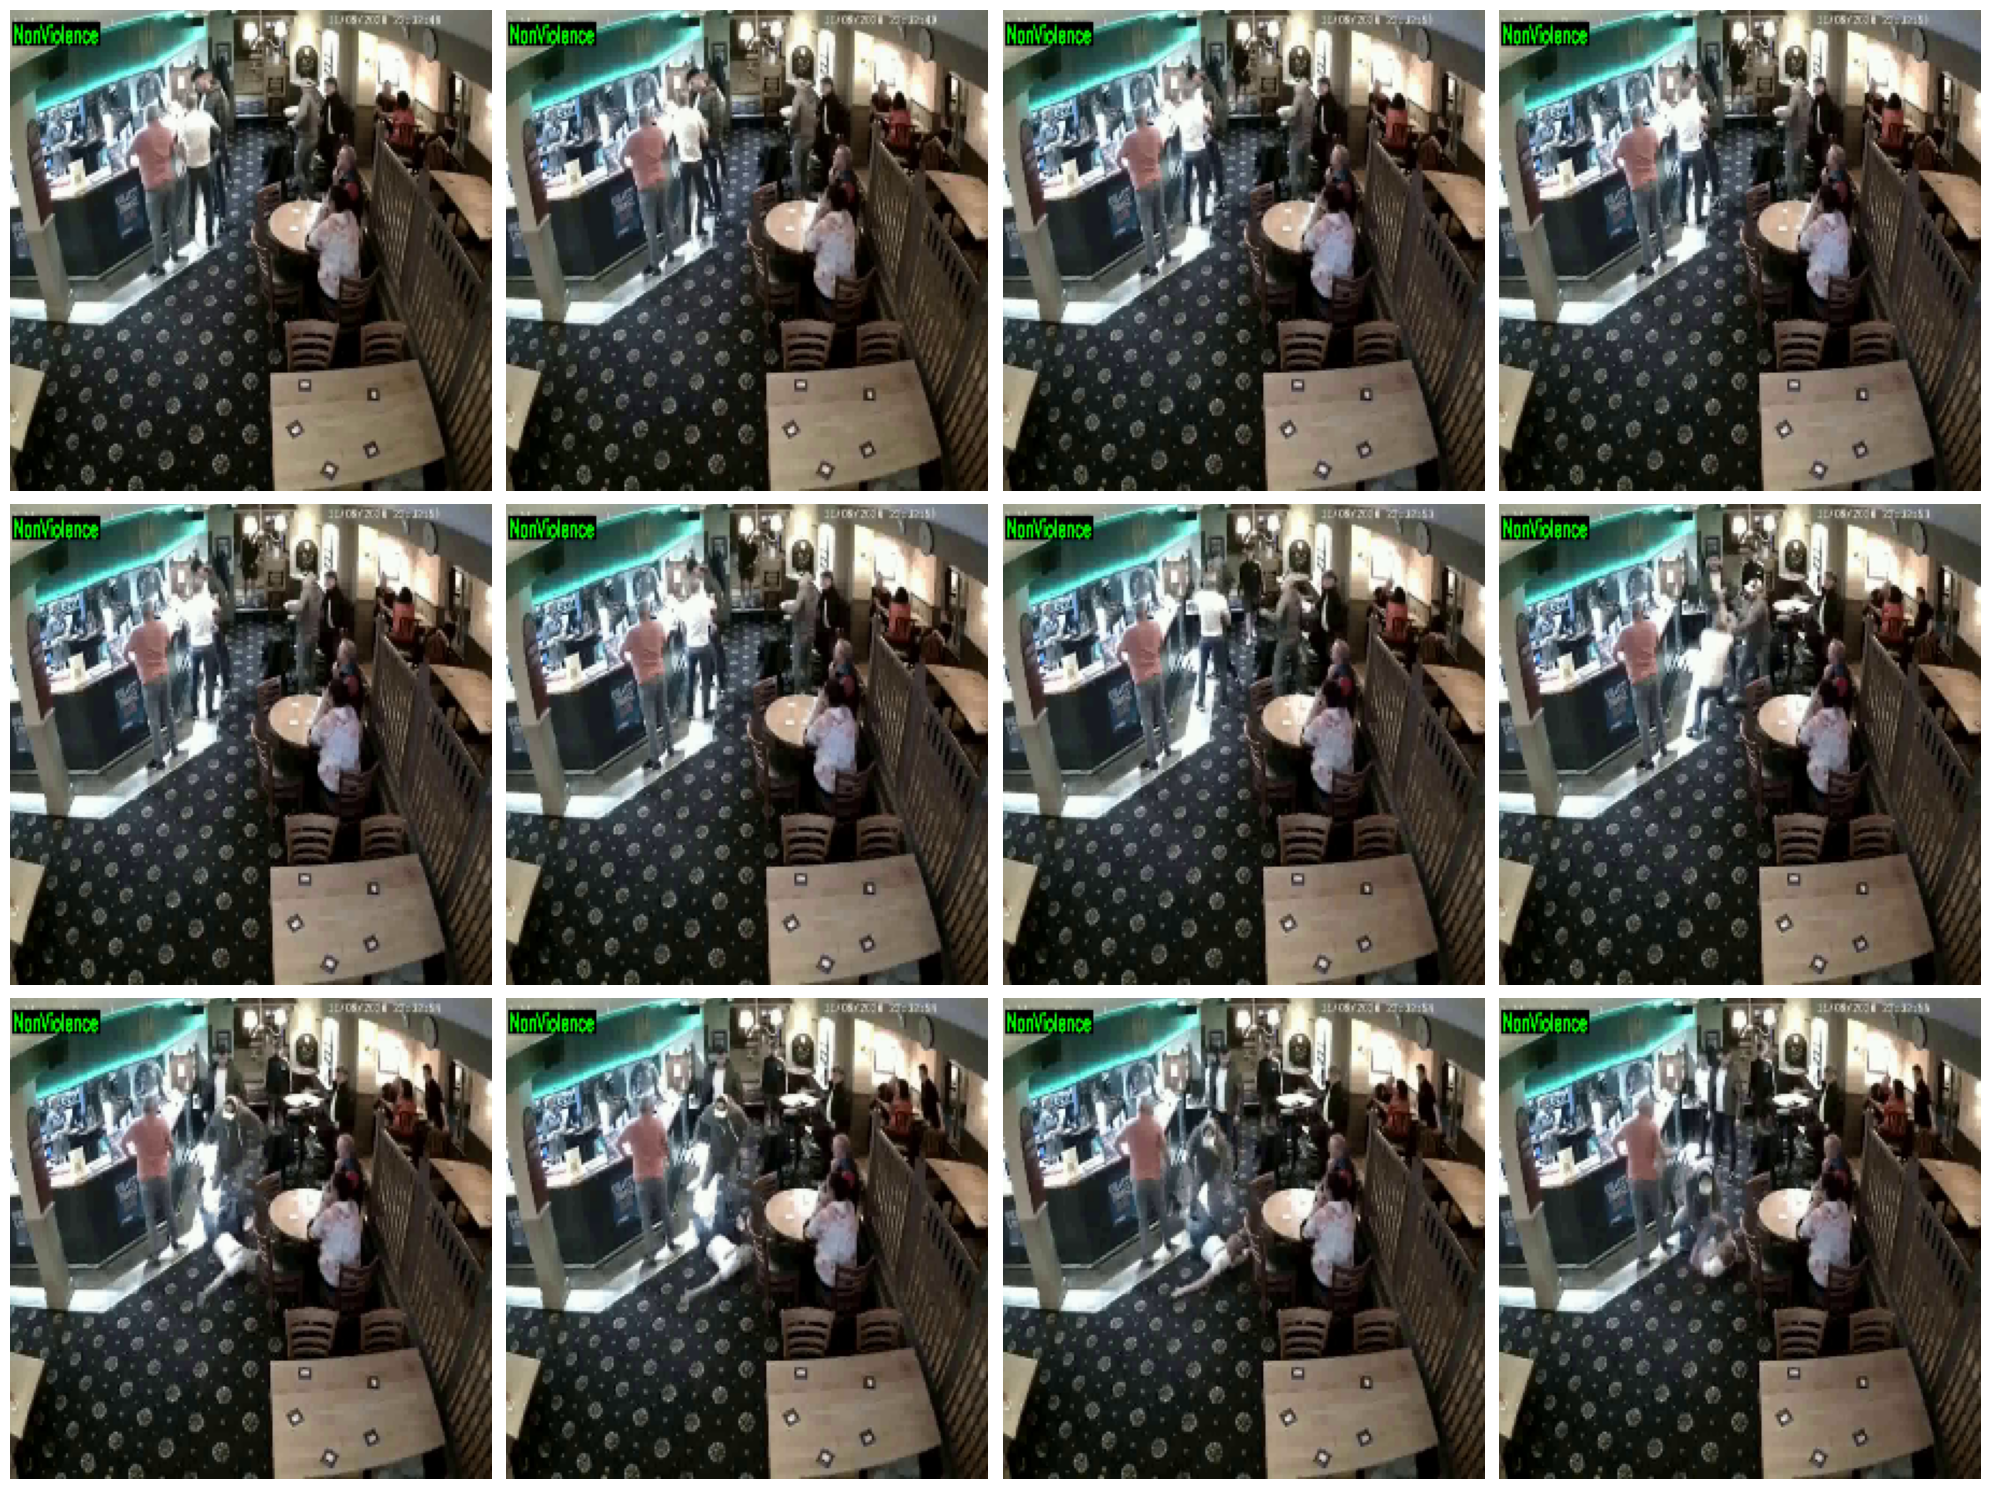

In [184]:
# Paths to input and output videos
input_video_file_path = r"C:\Users\sathv\Downloads\V.avi"

# Predict and annotate the video
predict_frames_vit(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display random annotated frames
show_pred_frames(output_video_file_path)
